# CNN with PyTorch
# Machine Learning, Exercise 9
 王敏行 id:2018012386 wangmx18@mails.tsinghua.edu.cn
 
**Codes in this document is accomplished with help of Yuhan Nong (The data loading part and testing part) and [JianShu online blog](https://www.jianshu.com/p/016a23bc6554)(the second netowrk in this notebook is adapted from the blog).**

Please see readme.md before running this file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision as tv
from torchvision import transforms

# np.random.seed(0)

## data loading part is accomplished with help
# 创建一个转换器，将torchvision数据集的输出范围[0,1]转换为归一化范围的张量[-1,1]。
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 创建训练集
# root -- 数据存放的目录
# train -- 明确是否是训练集
# download -- 是否需要下载
# transform -- 转换器，将数据集进行转换
trainset = tv.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 创建测试集
testset = tv.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
# 创建训练/测试加载器，
BATCH_SIZE = 512
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True)
# trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=True)

# 类别标签
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

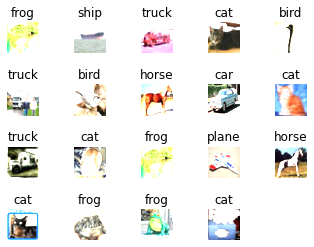

In [2]:

imlist = []
label_list = []
rand=np.random.randint(1,100,20)
for i in range(20):
    (data, label) = trainset[rand[i]]
    r = data[0].reshape(1024,1)
    g = data[1].reshape(1024,1)
    b = data[2].reshape(1024,1)
    p = (np.hstack((r,g,b))+1)
    pic = p.reshape(32,32,3)
    imlist.append(pic)
    label_list.append(label)

fig = plt.figure()
for i in range(1,20):
    ax = fig.add_subplot(4,5,i)
    plt.title(classes[label_list[i]])
    plt.axis('off')
    plt.imshow(imlist[i])
plt.subplots_adjust(wspace=0,hspace=1)
plt.show()

In [8]:
train_on_gpu = torch.cuda.is_available()
print('train on GPU:',train_on_gpu)

train on GPU: False


In [9]:
# I tried 2 models, the 2nd of which is much more complex.
# The second network is adapted from https://www.jianshu.com/p/016a23bc6554.

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class CnnNet1(nn.Module):
    def __init__(self):
        super(CnnNet1, self).__init__()
        self.conv1 = nn.Conv2d(3,3,5,stride = 2)        ## 32*32-->14*14
        self.maxpool = nn.MaxPool2d(2, stride = 2)      ## 14*14-->7*7
        self.conv2 = nn.Conv2d(3,3,3)                   ## 7*7-->5*5
        self.fc1 = nn.Linear(3*5*5,32)                  ## 3*5*5-->32
        self.fc2 = nn.Linear(32,10)
    
    def forward(self,x):
        x = F.sigmoid(self.conv1(x))           #3*32*32-->3*14*14
        x = self.maxpool(x)                 #3*14*14-->3*7*7
        x = F.sigmoid(self.conv2(x))           #3*7*7-->3*5*5
        # x = F.relu(self.maxpool(x))
        x = x.view(-1, 3*5*5)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return(x)



class CnnNet2(nn.Module):

    def __init__(self):
        super(CnnNet2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # 3*32*32 -> 16*32*32
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16*32*32 -> 16*16*16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),  # 16*16*16 -> 32*16*16
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32*16*16 -> 32*8*8
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  # 32*8*8 -> 64*8*8
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 64*8*8 -> 64*4*4
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64*4*4, 32),
            nn.ReLU(),
            # torch.nn.Dropout()
        )
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)               ## 3*32*32-->16*16*16
        x = self.conv2(x)               ## 16*16*16-->32*8*8
        x = self.conv3(x)               ## 32*8*8-->64*4*4
        x = x.view(-1, 64*4*4)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model1 = CnnNet1()
print(model1)
model2 = CnnNet2()
print(model2)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

CnnNet1(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=75, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
CnnNet2(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=

In [17]:
criterion = nn.CrossEntropyLoss()

def train(model, criterion, optimizer, trainloader, epochs=5, log_interval=50):
    print('----- Train Start -----')
    
    loss_list=[]
    loss_counter=[]
    for epoch in range(epochs):
        running_loss = 0.0
        for step, (batch_x, batch_y) in enumerate(trainloader):
            if train_on_gpu:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

            output = model(batch_x)

            optimizer.zero_grad()
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % log_interval == (log_interval-1):
                print('[%d, %5d] loss: %.4f' %
                      (epoch + 1, step + 1, running_loss / log_interval))
                loss_list.append(running_loss / log_interval)
                loss_counter.append(epoch)
                running_loss = 0.0
    print('----- Train Finished -----')
    return loss_list,loss_counter

def test(model, testloader):
    print('------ Test Start -----')

    correct = 0
    total = 0

    with torch.no_grad():
        for test_x, test_y in testloader:
            if train_on_gpu:
                test_x, test_y = test_x.cuda(), test_y.cuda()
            
            output = model(test_x)
            _, predicted = torch.max(output.data, 1)
            total += test_y.size(0)
            correct += (predicted == test_y).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network is: %.4f %%' % accuracy)
    return accuracy

----- Train Start -----


C:\Users\Max\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    50] loss: 2.2069
[2,    50] loss: 1.8904
[3,    50] loss: 1.7947
[4,    50] loss: 1.7349
[5,    50] loss: 1.6839
[6,    50] loss: 1.6534
[7,    50] loss: 1.6465
[8,    50] loss: 1.6287
[9,    50] loss: 1.6098
[10,    50] loss: 1.6129
[11,    50] loss: 1.6030
[12,    50] loss: 1.5873
[13,    50] loss: 1.5786
[14,    50] loss: 1.5933
[15,    50] loss: 1.5793
[16,    50] loss: 1.5817
[17,    50] loss: 1.5832
[18,    50] loss: 1.5819
[19,    50] loss: 1.5762
[20,    50] loss: 1.5797
----- Train Finished -----
------ Test Start -----
Accuracy of the network is: 42.2500 %


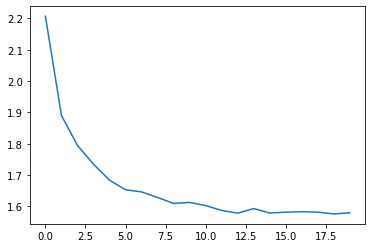

In [18]:
optimizer1 = torch.optim.SGD(model1.parameters(), lr=1, momentum=0.9)

loss_list,counter=train(model1, criterion, optimizer1, trainloader, epochs=20)
test(model1, testloader)
plt.figure()
plt.plot(counter, loss_list)
plt.show()

----- Train Start -----
[1,    50] loss: 2.3179
[2,    50] loss: 2.3059
[3,    50] loss: 2.1857
[4,    50] loss: 2.1805
[5,    50] loss: 2.1818
[6,    50] loss: 2.1798
[7,    50] loss: 2.1832
[8,    50] loss: 2.1791
[9,    50] loss: 2.1398
[10,    50] loss: 2.1293
[11,    50] loss: 2.1259
[12,    50] loss: 2.1241
[13,    50] loss: 2.1319
[14,    50] loss: 2.1308
[15,    50] loss: 2.1233
[16,    50] loss: 2.1281
[17,    50] loss: 2.1171
[18,    50] loss: 2.1239
[19,    50] loss: 2.1321
[20,    50] loss: 2.1302
----- Train Finished -----
------ Test Start -----
Accuracy of the network is: 19.7400 %


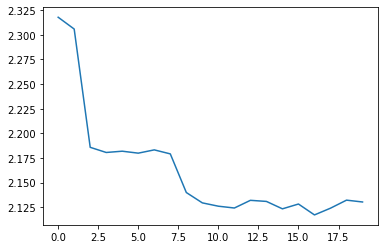

In [24]:
optimizer3 = torch.optim.SGD(model1.parameters(), lr=1, momentum=0.9, weight_decay=0.01)

loss_list,counter=train(model1, criterion, optimizer3, trainloader, epochs=20)
test(model1, testloader)
plt.figure()
plt.plot(counter, loss_list)
plt.show()

----- Train Start -----
[1,    50] loss: 0.7812
[2,    50] loss: 0.7641
[3,    50] loss: 0.7428
[4,    50] loss: 0.7240
[5,    50] loss: 0.7086
[6,    50] loss: 0.6910
[7,    50] loss: 0.6599
[8,    50] loss: 0.6596
[9,    50] loss: 0.6317
[10,    50] loss: 0.6219
[11,    50] loss: 0.6174
[12,    50] loss: 0.6010
[13,    50] loss: 0.5765
[14,    50] loss: 0.5729
[15,    50] loss: 0.5576
[16,    50] loss: 0.5406
[17,    50] loss: 0.5505
[18,    50] loss: 0.5267
[19,    50] loss: 0.5104
[20,    50] loss: 0.5058
----- Train Finished -----
------ Test Start -----
Accuracy of the network is: 71.7900 %


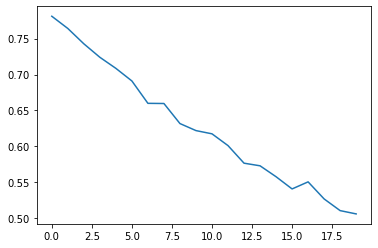

In [19]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

loss_list,counter=train(model2, criterion, optimizer2, trainloader, epochs=20)
test(model2, testloader)
plt.figure()
plt.plot(counter, loss_list)
plt.show()

----- Train Start -----
[1,    50] loss: 2.8447
[2,    50] loss: 1.6761
[3,    50] loss: 1.4604
[4,    50] loss: 1.3714
[5,    50] loss: 1.2861
[6,    50] loss: 1.2618
[7,    50] loss: 1.2202
[8,    50] loss: 1.1946
[9,    50] loss: 1.1457
[10,    50] loss: 1.1397
[11,    50] loss: 1.0890
[12,    50] loss: 1.0813
[13,    50] loss: 1.0448
[14,    50] loss: 1.0388
[15,    50] loss: 1.0063
[16,    50] loss: 0.9863
[17,    50] loss: 0.9699
[18,    50] loss: 0.9529
[19,    50] loss: 0.9478
[20,    50] loss: 0.9194
----- Train Finished -----
------ Test Start -----
Accuracy of the network is: 64.3700 %


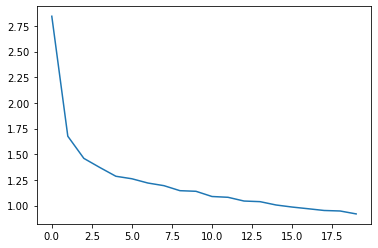

In [23]:
optimizer4 = torch.optim.Adam(model2.parameters(), lr=0.01)

loss_list,counter=train(model2, criterion, optimizer4, trainloader, epochs=20)
test(model2, testloader)
plt.figure()
plt.plot(counter, loss_list)
plt.show()